<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basic-imports-and-functions-and-data-loading" data-toc-modified-id="Basic-imports-and-functions-and-data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic imports and functions and data loading</a></span></li><li><span><a href="#Defining-subset-of-companies-based-on-time-intersection-and-dealing-with-missing-data" data-toc-modified-id="Defining-subset-of-companies-based-on-time-intersection-and-dealing-with-missing-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Defining subset of companies based on time intersection and dealing with missing data</a></span></li><li><span><a href="#Preparing-Datasets" data-toc-modified-id="Preparing-Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preparing Datasets</a></span></li></ul></div>

**DESCRIPTION**

This notebook contains code which make Data Cleaning operations. In order to do that efficiently, some EDA and visualization were applied here.

**Data Cleaning Process**
- Only 2 datasets were preprocessed here:
  - Company Profiles
  - Company Quotes
- Realized steps:
  - defining tickers in profiles with absense of quotes
  - defining period of time with most quotes available
  - replacing inter-period missing values in quotes (interpolation method)
  - EDA on categorical variables in Profiles and identyfying minor groups
  - defining and replacing missing values in Profiles
- Data Conversion
  - After cleaning processes, for Prices additional PCT-operation was applied for clustering Stage
  - All cleaned datasets saved to `datasets` folder for next stages usage


**Functions used**
- `create_grouped_df` - return DataFrame grouped by given param name from original DataFrame
- `check_and_replace_inf` - identify and replace np.inf to np.nan

### Basic imports and functions and data loading

In [1]:
# 1.1. necessary modules
import numpy as np
import pandas as pd
import os
import csv
import time
import warnings
from datetime import date as dt
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# 1.2. import funtions from project_lib

from project_lib import create_grouped_df, check_and_replace_inf

In [3]:
# 1.3. Data Loading (only profiles and quotes)

with open('data/profiles.csv', 'r', encoding='utf-8') as f:
    df_profiles = pd.read_csv(f, encoding='utf-8')
    df_profiles = df_profiles.drop(columns=['Unnamed: 0'], axis=1)
    

with open('datasets/df_prices.csv', 'r', encoding='utf-8') as f:
    df_prices_raw = pd.read_csv(f, encoding='utf-8')

### Defining subset of companies based on time intersection and dealing with missing data

In [4]:
# 2.1. Check profiles and datetime settings

no_quotes_comps = set(df_profiles.symbol.values) - set(df_prices_raw.columns[1:])

index_to_drop = []
for idx in df_profiles.index:
    if df_profiles.loc[idx, 'symbol'] in no_quotes_comps:
        index_to_drop.append(idx)
df_profiles = df_profiles.drop(index=index_to_drop, axis=0)
        
try:
    df_dates = pd.to_datetime(df_prices_raw['date'], format='%Y-%m-%d')
    df_prices_raw['date'] = df_dates
    df_prices_raw = df_prices_raw.set_index('date')
except Exception:
    pass

print(f'number of comps from profile list without quotes: {len(no_quotes_comps)}')

number of comps from profile list without quotes: 245


245 companies will be dropped from `df_profiles` dataframe

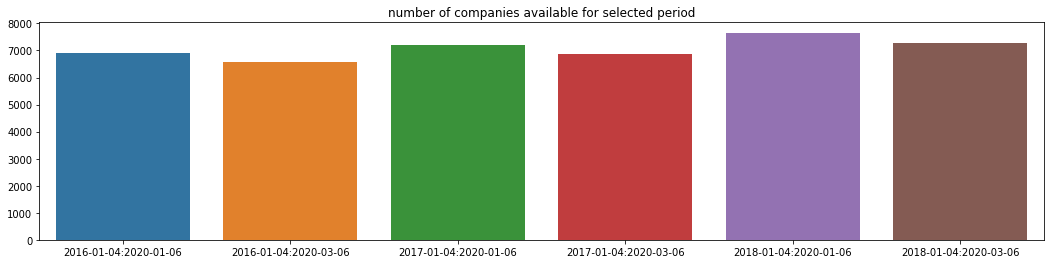

In [5]:
# 2.2. Discovering available time periods in quotes

start_dates = [pd.Timestamp(2016,1,4), pd.Timestamp(2017,1,4), pd.Timestamp(2018,1,4)]
end_dates = [pd.Timestamp(2020,1,6), pd.Timestamp(2020,3,6)]

comp_collections = dict()

for s in start_dates:
    for e in end_dates:
        d_key = str(s.date())+":"+str(e.date())
        comps = []
        for comp in df_prices_raw.columns:
            start_price = df_prices_raw.loc[s, comp]
            end_price = df_prices_raw.loc[e, comp]
            if not math.isnan(start_price) and not math.isnan(end_price):
                comps.append(comp)
        comp_collections[d_key] = (len(comps), comps)

x, y = [], []
for key, value in comp_collections.items():
    x.append(key)
    y.append(value[0])

plt.figure(figsize=(18,4))
sns.barplot(x,y)
plt.title('number of companies available for selected period')
plt.show()

chosen_start_date = pd.Timestamp(2016,1,4)
chosen_end_date = pd.Timestamp(2020,1,6)
chosen_tickers = comp_collections[str(chosen_start_date.date())+":"+str(chosen_end_date.date())][1]

As shown above:
- In average - 70-75% of tickers are available
- For next steps  {2016-01-04: 2020-01-06} as main period was chosen
- Number of companies available for this period ~ 6900 companise inside

In [6]:
# 2.3. Slicing Data by Chosen Period for Prices and Profiles
df_prices_raw_filtered = df_prices_raw[chosen_tickers]

index_to_drop = []
for idx in df_profiles.index:
    if df_profiles.loc[idx, 'symbol'] not in chosen_tickers:
        index_to_drop.append(idx)
    
df_profiles_filtered = df_profiles.drop(index=index_to_drop, axis=0)

In total - 6897 companies remained

In [7]:
# 2.4. Dealing with Inter-period NANS

total_nans = df_prices_raw_filtered.isna().sum().sum()
avg_nan_per_company = total_nans / df_prices_raw_filtered.shape[1]

print(f'total nans = {total_nans} ({100*total_nans/df_prices_raw_filtered.size:.2f}%)')
print(f'average number of nans per company: {avg_nan_per_company:.0f}')

# 4.1. Replacing nans by interpolate method
for comp in df_prices_raw_filtered.columns:
    df_prices_raw_filtered[comp] = df_prices_raw_filtered[comp].interpolate()

total nans = 238303 (3.19%)
average number of nans per company: 35


For replacing NANs in prices - interpolation method was chosen

missing values per column
------------------------------


symbol            0
companyName      49
sector          929
industry        929
exchange          0
description     100
ceo            3178
mktCap           44
dtype: int64

------------------------------
average marker cap is 6.5 billion usd


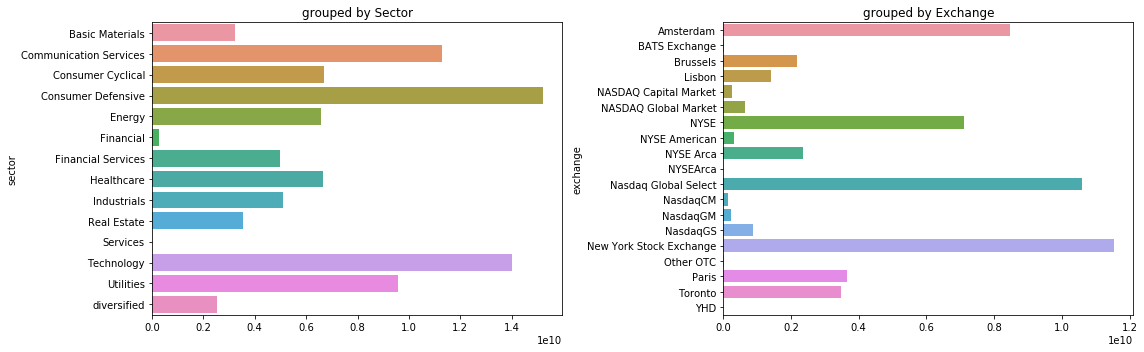

In [8]:
# 2.5. Identifying NANS and filling categorical variables in Profiles

print('missing values per column')
print(30*'-')
display(df_profiles_filtered.isna().sum())
print(30*'-')

df_profiles_filtered.industry = df_profiles_filtered.industry.fillna(value='diversified')
df_profiles_filtered.sector = df_profiles_filtered.sector.fillna(value='diversified')

# 5.2. EDA on MarketCap
avg_mktcap = df_profiles_filtered.mktCap.mean()
print(f'average marker cap is {avg_mktcap/1e9:.1f} billion usd')

df_by_sector = create_grouped_df('sector', df_profiles_filtered)
df_by_exchange = create_grouped_df('exchange', df_profiles_filtered)

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].set_title('grouped by Sector')
ax[1].set_title('grouped by Exchange')
sns.barplot(data=df_by_sector.T, orient='h', ax=ax[0])
sns.barplot(data=df_by_exchange.T, orient='h', ax=ax[1])
plt.tight_layout()
plt.show()

From above:
- There are some NANS in categorical features in Profiles
- Averaged market cap per group presented in the plots 
- All missing values in Sector and Industry were included to new category (for both features) - Diversified
- Missing values for {name, ceo, description} not replaced, since those features will not used in next steps
- Missing values in mktCap will be replaced bellow

In [9]:
# 5.3. Filling NANS in mktCap

nan_index = [i for i in df_profiles_filtered.index if math.isnan(df_profiles_filtered.mktCap.loc[i])]
for idx in nan_index:
    sect = df_profiles_filtered.sector.loc[idx]
    avg_mktcap = float(df_by_sector.loc[df_by_sector.index == sect].mktCap)
    df_profiles_filtered.mktCap.loc[idx] = avg_mktcap

avg_mktcap = df_profiles_filtered.mktCap.mean() # for 2 unidentified samples
df_profiles_filtered.mktCap = df_profiles_filtered.mktCap.fillna(avg_mktcap)

Missing values in mktCap was replaced with averaged per group (sector) values

### Preparing Datasets

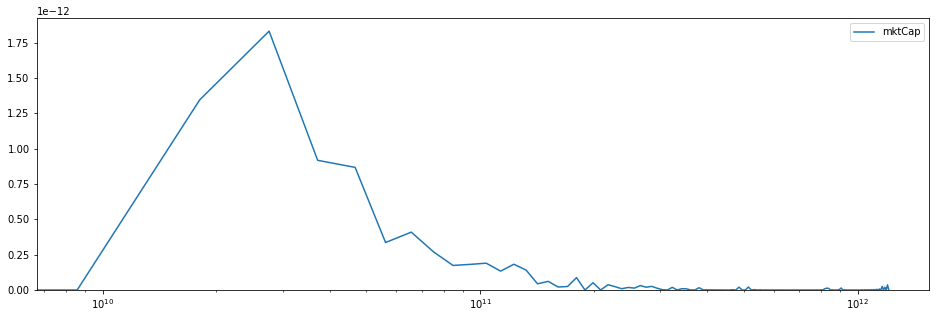

In [10]:
# 3.1. Visual look on mktCap

fig, ax = plt.subplots(1,1, figsize=(16,5))
mktcap = df_profiles_filtered.mktCap
ax.set_xscale('log')
axes=sns.kdeplot(mktcap)
plt.show()

As it shown above, mktCap density is highly left-skewed (x-axis - in logarithmic scale).  
Because of that, I will not categorize it and use for modelling.

In [11]:
# 3.2. DataSet for Modelling
# -- attention: this cell takes up to 3 minutes

# PCT
df_prices_pct = df_prices_raw_filtered.pct_change()
df_prices_pct = df_prices_pct.iloc[1:]
print(f'generated nans before interpolation: {df_prices_pct.isna().sum().sum()}')

# Interpolation
for comp in df_prices_pct.columns:
    df_prices_pct[comp] = df_prices_pct[comp].interpolate()
print(f'generated nans after pad-interpolation: {df_prices_pct.isna().sum().sum()}')

# checking Inf numbers
df_prices_pct = check_and_replace_inf(df_prices_pct, show_inf=True)
print(f'generated nans after inf-replacement: {df_prices_pct.isna().sum().sum()}')

# nan-replacement
comps_with_nans = []
for comp in df_prices_pct.columns:
    if df_prices_pct[comp].isna().sum()>0:
        comps_with_nans.append(comp)

print(f'nans still for in {comps_with_nans}')
df_prices_pct = df_prices_pct.drop(columns=comps_with_nans, axis=1)
print(f'generated nans after excluding comps: {df_prices_pct.isna().sum().sum()}')

generated nans before interpolation: 624
generated nans after pad-interpolation: 474
in GHG: 4 inf values
in GIX: 22 inf values
in LIG.LS: 2 inf values
in MLGEQ.PA: 1 inf values
in OSW: 136 inf values
in RCP: 1 inf values
in UBX: 4 inf values
generated nans after inf-replacement: 644
nans still for in ['GHG', 'GIX', 'LIG.LS', 'MLGEQ.PA', 'OSW', 'RCP', 'UBX']
generated nans after excluding comps: 0


The following manipulations done in datasets:
- for clusterization purposes NetPriceMargin will be used instead of Prices
  - NetPriceMargin = (P(t) - P(t-1)) / P(t-1)
  - such type of normalization neutralize price scale differences between companies
  - pandas function `pct_change()` is used for that
- after pct np.nan could be generated, so missing values additionally identified and replaced with pad-interpolation
- first date were dropped from the dataframe

In [12]:
# 3.3 Saving created and modified dataframes to DATASETS folder

# 4.1. saving cleaned stock prices
with open('datasets/df_prices_cleaned.csv', 'w', encoding='utf-8') as f:
    df_prices_raw_filtered.to_csv(f, encoding='utf-8', columns=df_prices_raw_filtered.columns)

# 4.2.saving cleaned stock prices Delta Margin
with open('datasets/df_prices_margin_cleaned.csv', 'w', encoding='utf-8') as f:
    df_prices_pct.to_csv(f, encoding='utf-8', columns=df_prices_pct.columns)

# 4.3. saving cleaned profile dataframe
with open('datasets/df_profiles_cleaned.csv', 'w', encoding='utf-8') as f:
    df_profiles_filtered.to_csv(f, encoding='utf-8', columns=df_profiles_filtered.columns)
    